# Volatility Arbitrage Strategy

In [12]:
# import all necessary library
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from functools import partial
import warnings
import os

## Data Cleaning

- retrieve spx option data from Bloomberg
- retrieve spx index data from yhoo finance
- clean data
  - unnecessary rows and columns
  - option ticker breakdown
  - expiration date format
  - keep options with certain expiration date which have more than 10 implied volatility
  - calculate moneyness
  - save the term structure of options


In [2]:
# import option data csv file
# os.chdir('D:/Github/volatility_arbitrage/SPX_option_price/20230901/')
option_data = pd.read_csv('./Public/data/option_price/20230901/spx_option_0901.csv')

option_data = option_data.dropna()

# ticker breakdown for call
option_data[['Index', 'Expiry', 'strike']] = option_data['Ticker'].str.split(' ', expand=True)
option_data['Type'] = option_data['strike'].str[0]
option_data.drop(['strike'], axis=1, inplace=True)

# ticker breakdown for put
option_data[['Index.1', 'Expiry.1', 'strike']] = option_data['Ticker.1'].str.split(' ', expand=True)
option_data['Type.1'] = option_data['strike'].str[0]
option_data.drop(['strike'], axis=1, inplace=True)

# spit call and put data
call_data = option_data[option_data.columns[~option_data.columns.str.contains('.1')]]
put_data = option_data[option_data.columns[option_data.columns.str.contains('.1')]]
put_data.columns = call_data.columns
call_data = call_data[['Ticker', 'Index', 'Type', 'Expiry', 'Strike', 'Bid', 'Ask', 'Last', 'Volm', 'IVM']]
put_data = put_data[['Ticker', 'Index', 'Type', 'Expiry', 'Strike', 'Bid', 'Ask', 'Last', 'Volm', 'IVM']]

# redefine option data as call concat put, convert strike to integer, convert expiry to string format, sort data by expiray and strike, delete 0 volume rows 
option_data = pd.concat([call_data, put_data], axis=0)
option_data['Strike'] = option_data['Strike'].astype(int)
option_data['Expiry'] = pd.to_datetime(option_data['Expiry'], format='%m/%d/%y')
option_data['Expiry'] = option_data['Expiry'].dt.date
option_data = option_data.sort_values(by=['Type', 'Expiry', 'Index', 'Strike'])
option_data['Expiry'] = option_data['Expiry'].astype(str)
option_data = option_data[option_data['Volm'] != 0]

option_data.head(10)

,Ticker,Index,Type,Expiry,Strike,Bid,Ask,Last,Volm,IVM
610,SPX 9/15/23 C4470,SPX,C,2023-09-15,4470,66.699997,67.699997,68.380005,16.0,10.665597
611,SPX 9/15/23 C4475,SPX,C,2023-09-15,4475,62.900009,63.900009,61.449997,18.0,10.570473
612,SPX 9/15/23 C4480,SPX,C,2023-09-15,4480,59.100006,60.199997,53.169998,6.0,10.464067
614,SPX 9/15/23 C4490,SPX,C,2023-09-15,4490,52.000000,53.000000,52.119995,11.0,10.279760
615,SPX 9/15/23 C4495,SPX,C,2023-09-15,4495,48.599991,49.599991,48.669998,6.0,10.197698
616,SPX 9/15/23 C4500,SPX,C,2023-09-15,4500,45.300003,46.300003,45.800003,7161.0,10.115258
617,SPX 9/15/23 C4505,SPX,C,2023-09-15,4505,42.100006,43.000000,40.900009,3.0,10.016058
618,SPX 9/15/23 C4510,SPX,C,2023-09-15,4510,39.000000,40.000000,37.680008,2744.0,9.946471
619,SPX 9/15/23 C4515,SPX,C,2023-09-15,4515,36.100006,37.000000,37.000000,6423.0,9.867279
620,SPX 9/15/23 C4520,SPX,C,2023-09-15,4520,33.399994,34.099991,33.869995,5719.0,9.802146


In [3]:
# keep expiry with enough implied volatility data
expiry_list = option_data['Expiry'].unique()
expiry_keep = []

for expiry in expiry_list:
    # for each expiry, get the unique strike
    option_data_expiry = option_data[option_data['Expiry'] == expiry]
    option_strike = option_data_expiry['Strike'].unique()
    # if strike_keep has more than 10 unique strike, keep the expiry
    if len(option_strike) > 10:
        expiry_keep.append(expiry)

option_data = option_data[option_data['Expiry'].isin(expiry_keep)]

expiry_list = option_data['Expiry'].unique()
print(expiry_list)

['2023-09-15' '2023-10-20' '2023-10-31' '2023-11-17' '2023-11-30'
 '2023-12-15' '2024-01-19' '2024-01-31' '2024-02-16' '2024-03-15'
 '2024-03-28' '2024-04-19' '2024-05-17' '2024-06-21' '2024-06-28'
 '2024-09-20' '2024-12-20' '2025-06-20']


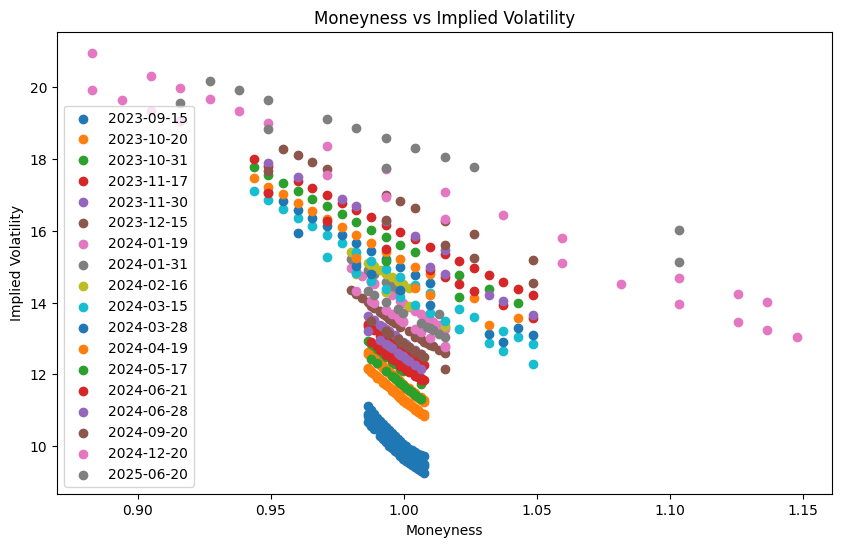

,Ticker,Index,Type,Expiry,Strike,Bid,Ask,Last,Volm,IVM,Moneyness
610,SPX 9/15/23 C4470,SPX,C,2023-09-15,4470,66.699997,67.699997,68.380005,16.0,10.665597,0.986624
611,SPX 9/15/23 C4475,SPX,C,2023-09-15,4475,62.900009,63.900009,61.449997,18.0,10.570473,0.987728
612,SPX 9/15/23 C4480,SPX,C,2023-09-15,4480,59.100006,60.199997,53.169998,6.0,10.464067,0.988831
614,SPX 9/15/23 C4490,SPX,C,2023-09-15,4490,52.000000,53.000000,52.119995,11.0,10.279760,0.991039
615,SPX 9/15/23 C4495,SPX,C,2023-09-15,4495,48.599991,49.599991,48.669998,6.0,10.197698,0.992142


In [4]:
# from yahoo finance, get the SPX historical price
def get_spx_hist(start, end):
    spx = yf.Ticker('^GSPC')
    spx_hist = spx.history(start=start, end=end)
    spx_hist = spx_hist.reset_index()
    spx_hist = spx_hist[['Date', 'Open']]
    spx_hist['Date'] = pd.to_datetime(spx_hist['Date'], format='%Y-%m-%d')
    spx_hist['Date'] = spx_hist['Date'].dt.date
    spx_hist['Date'] = spx_hist['Date'].astype(str)
    spx_hist = spx_hist.rename(columns={'Close':'SPX'})
    spx_hist = spx_hist.set_index('Date')
    spx_hist.to_csv(f'./Public/data/index_price/spx_hist_{start}_{end}.csv')
    return spx_hist

# spx_data = get_spx_hist('2021-09-01', '2023-11-07')
spx_data = pd.read_csv('./Public/data/index_price/spx_hist_2021-09-01_2023-11-07.csv', index_col='Date')

# calcualte moneyness
spx_0901 = spx_data.loc['2023-09-01', 'Open']
option_data['Moneyness'] =  option_data['Strike']  / spx_0901 

# plot moneyness vs IVM for each expiry
plt.figure(figsize=(10, 6))
for expiry in expiry_list:
    option_data_expiry = option_data[option_data['Expiry'] == expiry]
    plt.scatter(option_data_expiry['Moneyness'], option_data_expiry['IVM'], label=expiry)
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Moneyness vs Implied Volatility')
plt.legend()
plt.show()

test_option_data_0915 = option_data[option_data['Expiry'] == '2023-09-15']
display(test_option_data_0915.head())

## Fix Implied Volatility Surface

### Find BS Implied Volatility

- use put-call parity to calculate the risk-free rate and dividend yield for spx index option
  $$
  C-P = S_0e^{-qT}-Ke^{-rT}\\
  C-P = e^{-rT}(S_0e^{(r-q)T}-K) = e^{-rT}(F-K)\\
  $$
- use Black-Scholes model to calculate the implied volatility for each option
  - Black-Scholes model using forward price, the formula is:
    $$
    C = e^{-rT}(F\Phi(d_1)-K\Phi(d_2))\\
    P = e^{-rT}(K\Phi(-d_2)-F\Phi(-d_1))\\
    \displaystyle\text{where }d_1 = \frac{\ln(\frac{F}{K})+\frac{1}{2}\sigma^2T}{\sigma\sqrt{T}},\quad d_2 = d_1-\sigma\sqrt{T}, \quad \phi() \text{ is the standard normal pdf}
    
    $$
  - Use bisection method to get the implied volatility. 

### Fit BS Implied Volatility Surface

- calculate the implied volatility for each option using the implied volatility of the at-the-money option with the same expiration date
- for the same expiration date, fit the implied volatility curve against spot moneyness using function below:
  - option 1: similar to tanh function
    $$
    \sigma(x)^2 = \sigma_{atm}^2 + \delta\displaystyle\left(\frac{\tanh(\kappa x)}{\kappa}\right) + \frac{\gamma}{2}\left(\frac{\tanh(\kappa x)}{\kappa}\right)^2,\quad
    \text{where }x = \displaystyle\ln(\frac{K}{S})
    $$
  - option 2: similar to sigmoid function
- for different expiration date, for same moneyness, connect the implied volatility curve using cubic spline interpolation

### Convert BS Implied Volatility Surface to Local Volatility Surface

- use Dupire's formula to calculate the local volatility for each option
  $$
  \frac{\partial w}{\partial T} = v_L \left\{1 - \frac{y}{w}\frac{\partial w}{\partial y} + \frac{1}{4}\left(-\frac{1}{4}-\frac{1}{w}+\frac{y^2}{w^2}\right)\left(\frac{\partial w}{\partial y}\right)^2+\frac{1}{2}\frac{\partial^2 w}{\partial y^2}\right\}\\
  \text{where }w:=\text{ Black-Scholes implied variance},\quad y:= \ln(\frac{K}{F_T}), \quad v_L:=\text{ local volatility}
  $$

In [5]:
# ignore warning
warnings.simplefilter(action='ignore', category=FutureWarning)

# store call price and put price with same strike and expiry in the same row of a dataframe
option_price = pd.DataFrame(columns=['Strike', 'Expiry', 'c', 'p'])
option_data_spx = option_data[option_data['Index'] == 'SPX']
for expiry in expiry_list:
    # for each expiry
    option_data_expiry = option_data[option_data['Expiry'] == expiry]
    option_strike = option_data_expiry['Strike'].unique()

    for strike in option_strike:
        # for each strike
        option_data_strike = option_data_expiry[option_data_expiry['Strike'] == strike]
        
        # if call and put price exist, store the price in the dataframe
        # call_price = option_data_strike[option_data_strike['Type'] == 'C']['Last']
        # put_price = option_data_strike[option_data_strike['Type'] == 'P']['Last']
        # put price and call price are the mid price of bid and ask
        call_price = option_data_strike[option_data_strike['Type'] == 'C'][['Bid', 'Ask']].mean(axis=1)
        put_price = option_data_strike[option_data_strike['Type'] == 'P'][['Bid', 'Ask']].mean(axis=1)

        if not (call_price.empty or put_price.empty):
            call_price = call_price.values[0]
            put_price = put_price.values[0]

        temp_price = pd.DataFrame({'Strike': strike, 'Expiry': expiry, 'c': call_price, 'p': put_price}, index=[0])
        option_price = pd.concat([option_price, temp_price], axis=0)

# drop nan rows
option_price = option_price.dropna()

display(option_price.head())

,Strike,Expiry,c,p
0,4470,2023-09-15,67.199997,16.199997
0,4475,2023-09-15,63.400009,17.400002
0,4480,2023-09-15,59.650002,18.649994
0,4490,2023-09-15,52.500000,21.449997
0,4495,2023-09-15,49.099991,23.000000


['2023-09-15' '2023-10-20' '2023-11-17' '2023-12-15' '2024-01-19'
 '2024-02-16' '2024-03-15' '2024-04-19' '2024-05-17' '2024-06-21'
 '2024-09-20' '2024-12-20' '2025-06-20']


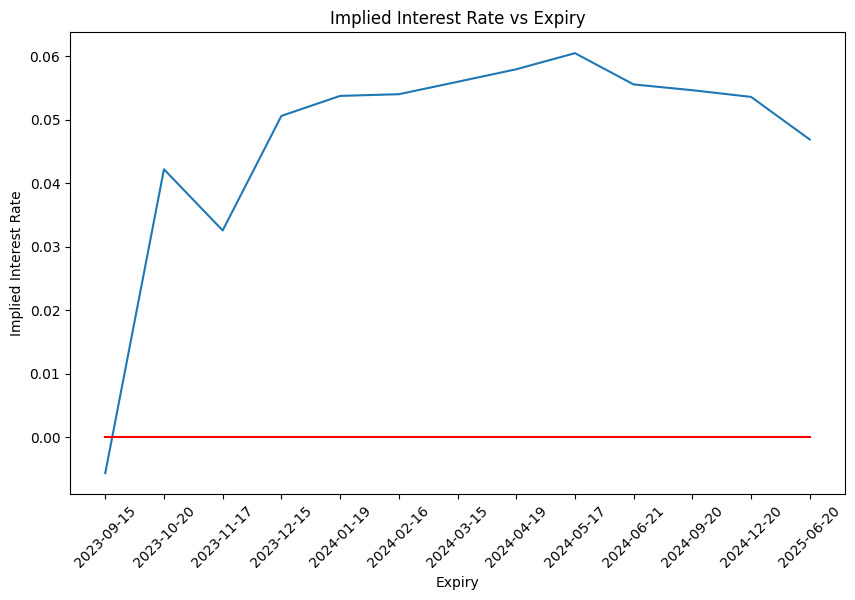

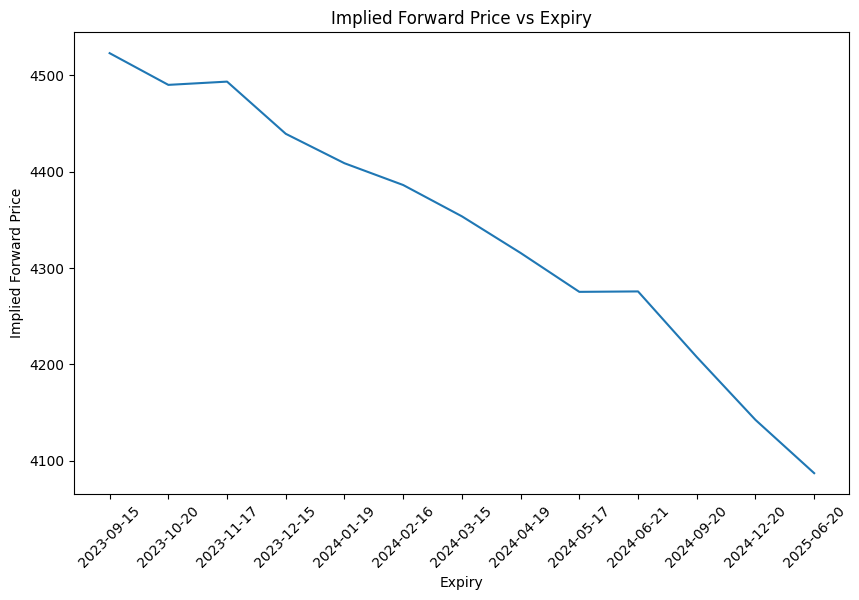

In [10]:
# ignore SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# use put call parity to calculate the risk free rate and forward price
expiry_list_spx = option_data_spx['Expiry'].unique()
print(expiry_list_spx)
def put_call_ir(plot, expiry_list=expiry_list):
    implied_params = pd.DataFrame(columns=['Expiry', 'implied_ir', 'implied_fwd'])
    
    today = pd.to_datetime('2023-09-01', format='%Y-%m-%d')

    for expiry in expiry_list:
        # for each expiry
        option_price_expiry = option_price[option_price['Expiry'] == expiry]
        option_price_expiry['c-p'] = option_price_expiry['c'] - option_price_expiry['p']

        # regress c-p on -strike to get risk free rate
        model = LinearRegression()
        x = option_price_expiry[['Strike']]
        y = option_price_expiry['c-p']
        T = (pd.to_datetime(expiry, format='%Y-%m-%d') - today).days / 365
        model.fit(x, y)
        discount_factor = -model.coef_[0]
        
        forward_price = model.intercept_ * discount_factor
        risk_free_rate = -np.log(discount_factor) / T

        implied_params = pd.concat([implied_params, pd.DataFrame({'Expiry': expiry, 'implied_ir': risk_free_rate, 'implied_fwd': forward_price}, index=[0])], axis=0)
                
        # plot c-p vs strike
        if plot:
            plt.figure(figsize=(10, 6))
            plt.scatter(option_price_expiry['Strike'], option_price_expiry['c-p'])
            plt.plot(option_price_expiry['Strike'], model.predict(x), color='red')
            plt.text(0.6, 0.8, f'c-p = {model.coef_[0]:.4f} * strike + {model.intercept_:.4f}', transform=plt.gca().transAxes)
            plt.xlabel('Strike')
            plt.ylabel('Call - Put')
            plt.title('Call - Put vs Strike')
            plt.show()
    
    return implied_params

# expiry_list_spx = ['2024-6-28']
implied_params = put_call_ir(False, expiry_list_spx)

# plot implied ir vs expiry
plt.figure(figsize=(10, 6))
plt.plot(implied_params['Expiry'], implied_params['implied_ir'])
plt.plot(implied_params['Expiry'], np.zeros(len(implied_params)), color='red')
plt.xticks(rotation=45)
plt.xlabel('Expiry')
plt.ylabel('Implied Interest Rate')
plt.title('Implied Interest Rate vs Expiry')
plt.show()

# plot implied fwd vs expiry
plt.figure(figsize=(10, 6))
plt.plot(implied_params['Expiry'], implied_params['implied_fwd'])
plt.xticks(rotation=45)
plt.xlabel('Expiry')
plt.ylabel('Implied Forward Price')
plt.title('Implied Forward Price vs Expiry')
plt.show()


In [13]:
# define BS model
def BS_fwd_pricer(F, K, T, sig, r, isCall):
    d1 = (np.log(F / K) + 0.5 * sig ** 2 * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    
    if isCall:
        option_price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        option_price = np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

    return option_price


######## not finished yet ########
spot = spx_data.loc['2023-09-01', 'Open']
strike = 4400
r = implied_params[implied_params['Expiry'] == '2023-09-15']['implied_ir'].values[0]
T = (pd.to_datetime('2023-09-15', format='%Y-%m-%d') - pd.to_datetime('2023-09-01', format='%Y-%m-%d')).days / 365
implied_vol_pricer = partial(BS_fwd_pricer, spot=spot, strike=strike, r=r, T=T)

# use bisection method to find implied volatility
def bisection_implied_vol(F, K, T, r, option_price, tol=0.05, isCall=True):
    # leave the isCall and sig as variables for the pricer
    implied_vol_pricer = partial(BS_fwd_pricer, spot=spot, strike=strike, r=r, q=q, T=T)

    # define the BS - p calculator
    def diff_calculator(isCall=True, sig=0.2):
        temp_price = implied_vol_pricer(isCall=isCall, sig=sig)
        price_diff = temp_price - option_price
        return price_diff

    # initialize the value of the range of sig, and calculate the option price based on historical volatility
    upper_bound = 1
    lower_bound = 0.01
    temp_sig = 0.5
    price_diff = 1

    # find two bounds of the root
    while diff_calculator(isCall=isCall, sig=lower_bound) > 0:
        lower_bound = lower_bound ** 2

    upper_bound = lower_bound
    while diff_calculator(isCall=isCall, sig=upper_bound) < 0:
        upper_bound = upper_bound * 1.2

    # bisection algo
    while abs(price_diff) >= tol:
        temp_sig = (lower_bound + upper_bound) / 2
        price_diff = diff_calculator(isCall=isCall, sig=temp_sig)

        if price_diff > 0:
            upper_bound = temp_sig
        else:
            lower_bound = temp_sig

    return temp_sig

## Trading Strategy

- if the implied volatility of an option is higher than the local volatility, then sell the option

## Backtesting

# To-do List
- after delete the rows with 0 volume, the moneyness with near expiration date is close to 0, it is hard to fit the implied volatility curve
- put call parity last price in 2023-09-15, the interest rate is negative. Using last price to calculate the risk-free rate fluctuates a lot. 
- Spot moneyness or forward moneyness?

# Reference

[How to Determine Implied Dividend Yield-Derivative Valuation in Excel](https://derivvaluation.medium.com/how-to-determine-implied-dividend-yield-derivative-valuation-in-excel-1078a9bc1f7f)  
[SPX vs. SPXW Options: Understanding the Key Differences](https://insideoptions.io/spx-spxw-options-differences/)  
[Cubic Spline Interpolation](https://en.wikipedia.org/wiki/Spline_interpolation#Algorithm_to_find_the_interpolating_cubic_spline)